In [1]:
import sys
sys.path.append('..')
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

from utilities import formatP, formatCell

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
files = glob.glob(f'*-SNP-overlapSummary.txt')
files.sort()
files.reverse()

In [4]:
results = {}
rawP = [] # Store in list for post correction
for file in files:
    cell1, cell2 = file.split('-')[:2]
    obs = pd.read_csv(file, sep='\t', index_col=0)
    chi2, p, dof, exp = chi2_contingency(obs)
    cell1 = formatCell(cell1)
    cell2 = formatCell(cell2)
    results[(cell1, cell2)] =  [chi2, p, dof, obs, exp]
    rawP.append(p)
_, adjP, _, _ = multipletests(rawP, method='bonferroni')

/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


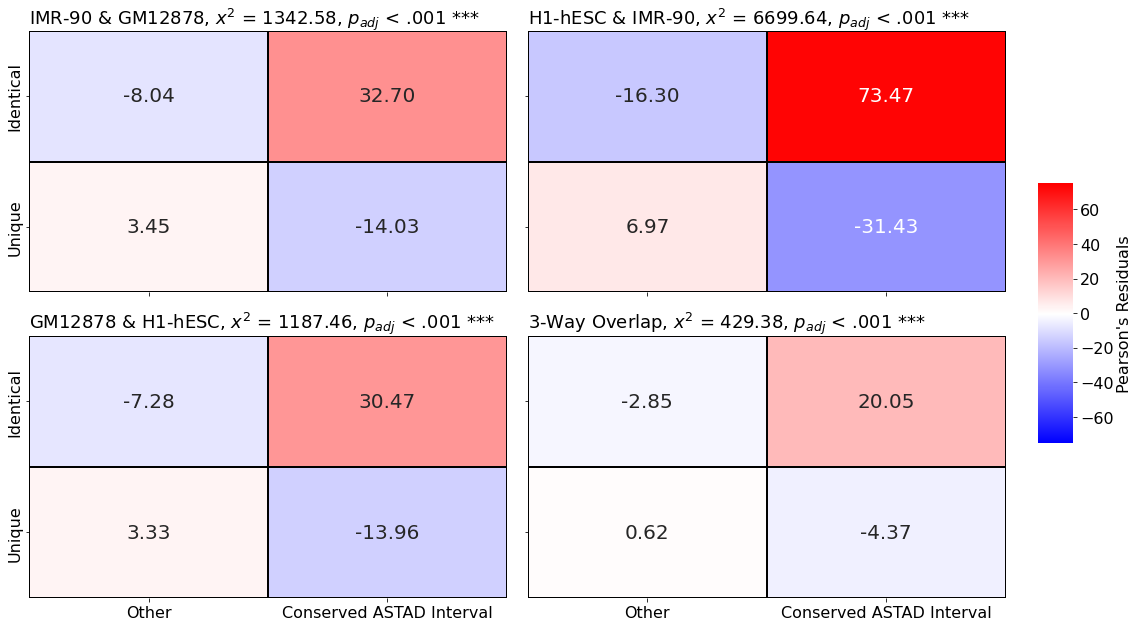

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16,9), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
axes = axes.flatten()
with pd.ExcelWriter(f'allChiData-Conserved.xlsx') as writer:
    for i, (cell1, cell2) in enumerate(results.keys()):
        chi2, p, dof, obs, exp = results[(cell1, cell2)]
        pearsonResiduals = (obs - exp) / (np.sqrt(exp))
        pearsonResiduals = pearsonResiduals.rename(
            {'ASTAD': 'Conserved ASTAD Interval', 'non-ASTAD': 'Other'}, axis=1)
        sns.heatmap(
            data=pearsonResiduals, annot=True, fmt='.2f',
            cbar_ax=(None if i else cbar_ax), cbar=(i==0),
            linewidths=1, linecolor='black', annot_kws={'fontsize':20},
            vmin=-75, vmax=75, center=0, cmap='bwr', cbar_kws={'label': 'Pearson\'s Residuals'},
            ax=axes[i])
        p = formatP(p)
        if i == 3:
            name = '3-Way Overlap'
        else:
            name = f'{cell1} & {cell2}'
        title = f'{name}, $x^2$ = {chi2:.2f}, $p_{{adj}}$ {p}'
        axes[i].set_title(title, loc='left', fontsize=18)
        obs.to_excel(writer, sheet_name=name)
fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig(f'SNPidentity.svg', dpi=300)

In [5]:
allData = pd.read_csv('variant-enrichment.txt', sep='\t').rename({'overlap': 'ASTAD'}, axis=1)
allData['non-ASTAD'] = allData['total'] - allData['ASTAD']
allData['genotype'] = allData['genotype'].apply(
    lambda x: 'Homozygous' if x == 'hom' else 'Heterozygous')


results = {}
rawP = [] # Store in list for post correction
for cell in ['GM12878', 'IMR90', 'H1hESC']:
    for var in ['snps', 'indels']:
        obs = allData.loc[
            (allData['cell'] == cell) & (allData['variant'] == var), 
            ['ASTAD', 'non-ASTAD', 'genotype']].set_index('genotype')
        obs.index = ['Heterozygous', 'Homozygous']
        obs = obs.T
        chi2, p, dof, exp = chi2_contingency(obs)
        results[(formatCell(cell), var)] =  [chi2, p, dof, obs, exp]
        rawP.append(p)
_, adjP, _, _ = multipletests(rawP, method='bonferroni')

/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


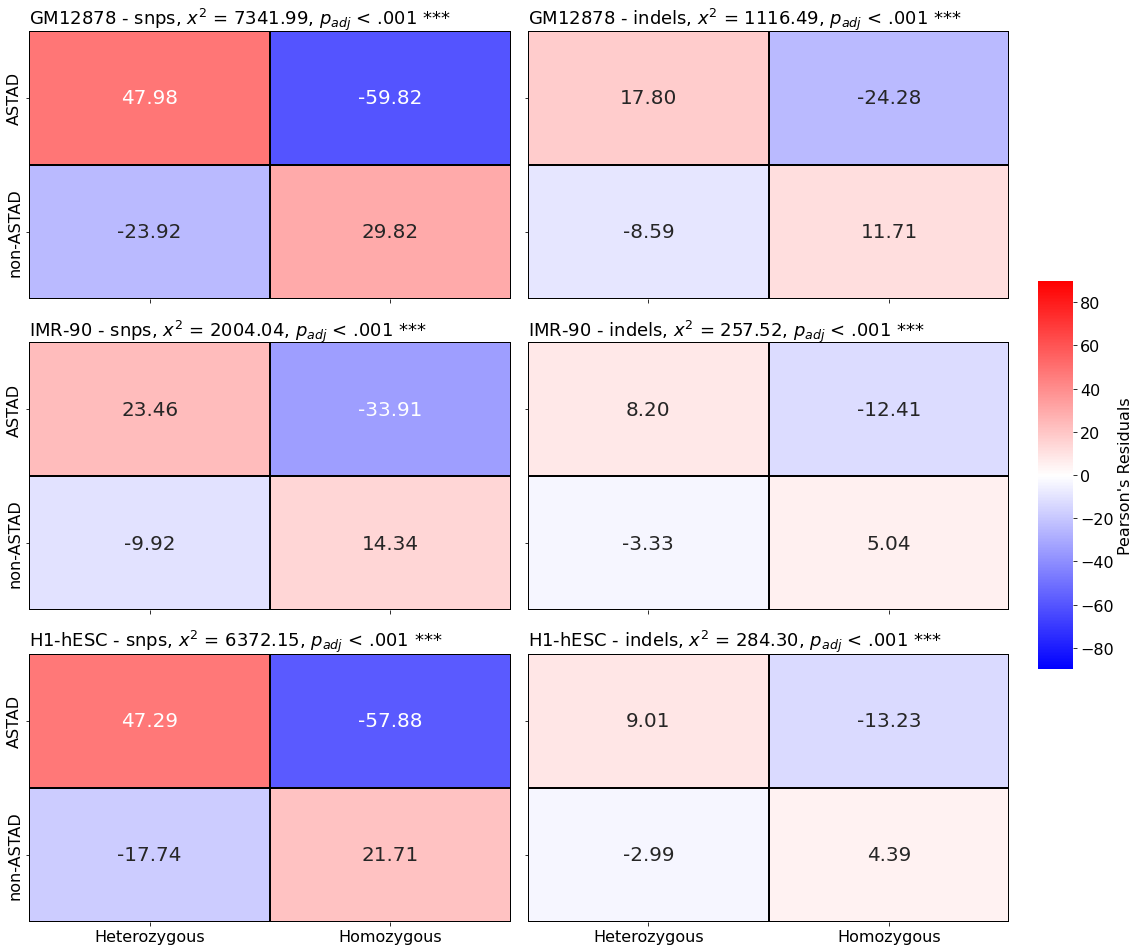

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(16,13.5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
axes = axes.flatten()
with pd.ExcelWriter(f'allChiData-Variant.xlsx') as writer:
    for i, (cell, var) in enumerate(results.keys()):
        chi2, p, dof, obs, exp = results[(cell, var)]
        pearsonResiduals = (obs - exp) / (np.sqrt(exp))
        cbar = False if i% 2 == 0 else True
        sns.heatmap(
            data=pearsonResiduals, annot=True, fmt='.2f',
            cbar_ax=(None if i else cbar_ax), cbar=(i==0),
            linewidths=1, linecolor='black', annot_kws={'fontsize':20},
            vmin=-90, vmax=90, center=0, cmap='bwr', ax=axes[i],
            cbar_kws={'label': 'Pearson\'s Residuals'})
        p = formatP(p)
        title = f'{cell} - {var}, $x^2$ = {chi2:.2f}, $p_{{adj}}$ {p}'
        axes[i].set_title(title, loc='left', fontsize=18)
        obs.to_excel(writer, sheet_name=f'{cell}-{var}')
fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig(f'VariantEnrichment.svg', dpi=300)